# **CityScapes Depth**

In this notebook, we will learn how to convert stereo image pairs from the cityscapes dataset into high quality depth maps, using CreStereo.

The resulting depth maps can then be used to train a model to perform monocular depth estimation, where the CreStereo model is acting as a teacher network that can distill knowledge into the student network.

In [6]:
!pip install torch torchvision	--q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 900.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [38]:
# unzip the dataset archive
!unzip cityscapes.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /data/train/image/526.npy  
  inflating: /data/train/image/527.npy  
  inflating: /data/train/image/528.npy  
  inflating: /data/train/image/529.npy  
  inflating: /data/train/image/53.npy  
  inflating: /data/train/image/530.npy  
  inflating: /data/train/image/531.npy  
  inflating: /data/train/image/532.npy  
  inflating: /data/train/image/533.npy  
  inflating: /data/train/image/534.npy  
  inflating: /data/train/image/535.npy  
  inflating: /data/train/image/536.npy  
  inflating: /data/train/image/537.npy  
  inflating: /data/train/image/538.npy  
  inflating: /data/train/image/539.npy  
  inflating: /data/train/image/54.npy  
  inflating: /data/train/image/540.npy  
  inflating: /data/train/image/541.npy  
  inflating: /data/train/image/542.npy  
  inflating: /data/train/image/543.npy  
  inflating: /data/train/image/544.npy  
  inflating: /data/train/image/545.npy  
  inflating: /data/train/image/546.npy  
  inflat

In [9]:
import os
from glob import glob
import sys

import cv2
import numpy as np

import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline


# local imports
sys.path.append(os.path.dirname(os.getcwd()))

#from nets import Model

### Configs

In [45]:
device = 'cuda'
root = "data"
#model_path = "../models/crestereo_eth3d.pth"
OG_W, OG_H = 2048, 1024   # OG width adn height
W1, H1 = OG_W, OG_H # resize w,h for dataloader
W2, H2 = W1//2, H1//2     # resize w,h for model inference

batch_size = 1
n_iter=20


baseline = 0.209313 # meters
f = 2262.52 # x focal length (pixels)

In [148]:
import torch
import torchvision.transforms.functional as F

class BottomCrop:
    def __init__(self, crop_pixels=25):
        self.crop_pixels = crop_pixels
    def __call__(self, x, c):
        # x: [3, H, W], c: [2, H, W]
        H = x.shape[1]
        new_H = H - self.crop_pixels
        x = x[:, :new_H, :]
        c = c[:, :new_H, :]
        return x, c

class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, x, c):
        if torch.rand(1) < self.p:
            x = F.hflip(x)
            c = F.hflip(c)
        return x, c

class NormalizeImageOnly:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, x, c):
        x = F.normalize(x, mean=self.mean, std=self.std)
        return x, c

class DualCompose:
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, x, c):
        for t in self.transforms:
            x, c = t(x, c)
        return x, c


# Then in your dataset code:
transform_train = DualCompose([
    BottomCrop(crop_pixels=50),
    RandomHorizontalFlip(p=0.5),
    NormalizeImageOnly(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

transform_val = DualCompose([
    BottomCrop(crop_pixels=50),
    NormalizeImageOnly(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])


In [149]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset

class CityscapeDepthSemanticDataset(Dataset):
    """
    A custom PyTorch Dataset that loads:
      - image files (RGB) from data/<split>/image
      - depth maps      from data/<split>/depth
      - label maps      from data/<split>/label

    It returns (x, c) where:
      - x is the RGB image  (3, H, W)
      - c is the condition: [depth, label]  (2, H, W)
    """
    def __init__(self, data_dir, split='train', transform=None):
        """
        Args:
            data_dir (str): Root directory of your data, e.g. 'data'.
            split (str): 'train' or 'val' or 'test'.
            transform (callable, optional): A function that takes (x, c) and returns (x, c).
        """
        self.data_dir = data_dir
        self.split = split
        self.transform = transform

        # Directories for images, depth, and labels
        self.image_dir = os.path.join(data_dir, split, 'image')
        self.depth_dir = os.path.join(data_dir, split, 'depth')
        self.label_dir = os.path.join(data_dir, split, 'label')

        # Gather file names
        self.image_files = sorted(os.listdir(self.image_dir))
        self.depth_files = sorted(os.listdir(self.depth_dir))
        self.label_files = sorted(os.listdir(self.label_dir))

        # Optional check for matching file counts
        assert len(self.image_files) == len(self.depth_files) == len(self.label_files), \
            f"Mismatch in file counts for {split} split."

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Full paths
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        depth_path = os.path.join(self.depth_dir, self.depth_files[idx])
        label_path = os.path.join(self.label_dir, self.label_files[idx])

        # Load .npy
        image = np.load(image_path)  # shape (H, W, 3)
        depth = np.load(depth_path)  # shape (H, W) or (H, W, 1)
        label = np.load(label_path)  # shape (H, W) or (H, W, 1)

        # Ensure depth has shape (H, W, 1)
        if depth.ndim == 2:
            depth = depth[..., np.newaxis]

        # Ensure label has shape (H, W, 1)
        if label.ndim == 2:
            label = label[..., np.newaxis]

        # Concatenate depth + label => shape (H, W, 2)
        c = np.concatenate([depth, label], axis=-1)

        # Convert to torch tensors (float) and permute to [C, H, W]
        x = torch.from_numpy(image).permute(2, 0, 1).float()  # [3, H, W]
        c = torch.from_numpy(c).permute(2, 0, 1).float()      # [2, H, W]

        # Apply optional transform (x, c) -> (x, c)
        if self.transform is not None:
            x, c = self.transform(x, c)

        return x, c


In [153]:
from torch.utils.data import DataLoader

data_dir = "data"  # Replace with your data folder
train_dataset = CityscapeDepthSemanticDataset(
    data_dir=data_dir,
    split='train',
    transform=None  # or some transform function
)
val_dataset = CityscapeDepthSemanticDataset(
    data_dir=data_dir,
    split='val',
    transform=None
)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4
)
val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4
)

# Quick check
for i, (x, c) in enumerate(train_loader):
    print("x shape:", x.shape)  # [B, 3, H, W]
    print("c shape:", c.shape)  # [B, 2, H, W]
    break


x shape: torch.Size([8, 3, 128, 256])
c shape: torch.Size([8, 2, 128, 256])


# visualize

In [154]:
batch = next(iter(train_loader))
images, conditions = batch

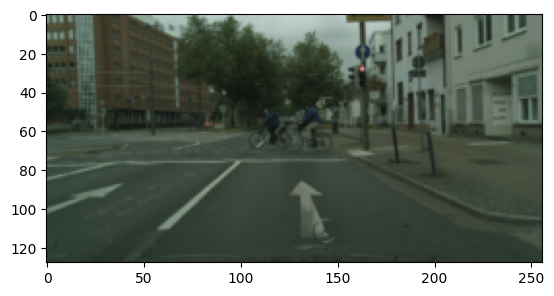

In [155]:
# visualize the image
plt.imshow(images[0].permute(1, 2, 0))

In [156]:
#inflate the condition channels add a zero channel
conditions = torch.cat([conditions, torch.zeros_like(conditions[:, :1])], dim=1)
print(conditions.shape)




torch.Size([8, 3, 128, 256])


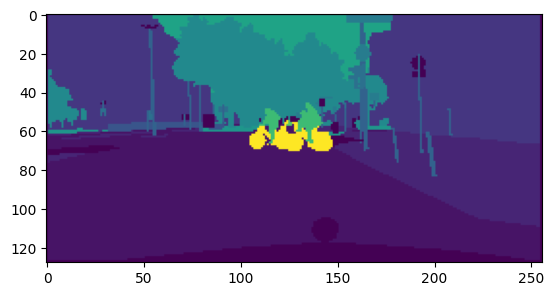

In [157]:
# visualize the condition
plt.imshow(conditions[0,1])


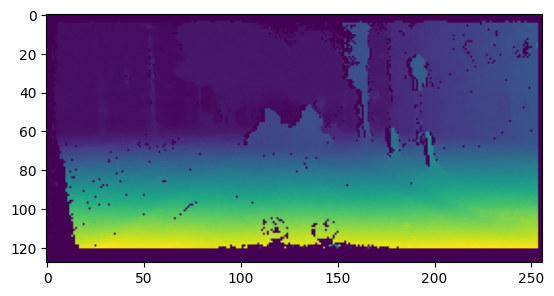

In [162]:
# visualize the condition
plt.imshow(conditions[0,0])


# now to the architecture

## conv block

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv_block(in_channels, out_channels):
    """
    A simple 2-convolution block:
      Conv -> ReLU -> Conv -> ReLU
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )


In [166]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=2):
        """
        Args:
            in_channels (int): number of channels in the input tensor
                               (e.g. 5 if (x + c) = (3 + 2)).
            out_channels (int): number of channels in the output.
        """
        super().__init__()
        # Encoder layers
        self.enc1 = conv_block(in_channels, 32)  # 5 -> 32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = conv_block(32, 64)           # 32 -> 64
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = conv_block(64, 128)    # 64 -> 128

        # Decoder layers
        # up1: 128 -> 64, then skip connect with enc2
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(64 + 64, 64)

        # up2: 64 -> 32, then skip connect with enc1
        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = conv_block(32 + 32, 32)

        # final output conv
        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        """
        x shape: [B, in_channels, H, W]
        returns shape: [B, out_channels, H, W]
        """
        # Encoder
        e1 = self.enc1(x)         # [B, 32, H,   W]
        p1 = self.pool1(e1)       # [B, 32, H/2, W/2]

        e2 = self.enc2(p1)        # [B, 64, H/2,   W/2]
        p2 = self.pool2(e2)       # [B, 64, H/4,   W/4]

        # Bottleneck
        b = self.bottleneck(p2)   # [B, 128, H/4,  W/4]

        # Decoder
        up1 = self.up1(b)         # [B, 64, H/2, W/2]
        # Concat skip from e2
        cat1 = torch.cat([up1, e2], dim=1)   # [B, 64+64=128, H/2, W/2]
        d1 = self.dec1(cat1)                # [B, 64, H/2, W/2]

        up2 = self.up2(d1)         # [B, 32, H, W]
        # Concat skip from e1
        cat2 = torch.cat([up2, e1], dim=1)   # [B, 32+32=64, H, W]
        d2 = self.dec2(cat2)                # [B, 32, H, W]

        # Final 1x1 conv
        out = self.out_conv(d2)   # [B, out_channels, H, W]
        return out


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


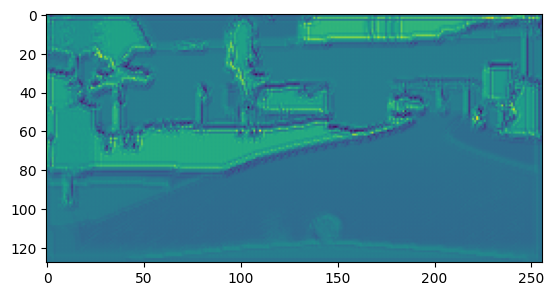

In [172]:
batch = next(iter(train_loader))
images, conditions = batch
simple_unet = SimpleUNet()
a = simple_unet(conditions)
plt.imshow(a[0,0].detach().numpy())

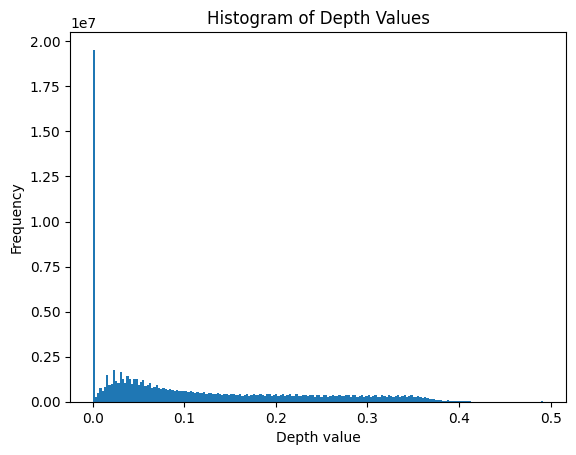

In [158]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

# 1. Define (or import) your dataset
# from your_code import CityscapeDepthSemanticDataset  # if it's in another file

data_dir = 'data'
split = 'train'
dataset = CityscapeDepthSemanticDataset(data_dir=data_dir, split=split)

# 2. Collect depth values from the entire dataset (or a subset)
depth_values = []

# Caution: This can take a while if your dataset is large!
for i in range(len(dataset)):
    # We don't need the RGB image here, just the condition c
    _, c = dataset[i]  # c has shape [2, H, W]: c[0] = depth, c[1] = labels
    depth = c[0].numpy()  # shape [H, W]
    depth_values.append(depth.flatten())  # Flatten and store

# 3. Concatenate into a single NumPy array
depth_values = np.concatenate(depth_values, axis=0)

# 4. Plot the histogram
plt.figure()
plt.hist(depth_values, bins=200)  # Adjust bins as needed
plt.xlabel("Depth value")
plt.ylabel("Frequency")
plt.title("Histogram of Depth Values")
plt.show()


## CityScapes data

We have stored the cityscapes data in the following structure

- cityscapes
    - rightImg8bit
        - train
        - val
        - test
    - leftImg8bit
        - train
        - val
        - test

We will create a simple dataloader to load and preprocess the images so that the disparity can be computed

In [159]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CityScapesStereo(Dataset):
    def __init__(self, root, transform=None, split='train', return_paths=False):
        self.root = root
        self.transform = transform
        self.return_paths = return_paths

        self.left_paths = glob(os.path.join(root, 'leftImg8bit', split, '**\*.png'))
        self.right_paths = glob(os.path.join(root, 'rightImg8bit', split, '**\*.png'))


    def __getitem__(self, idx):
        left = cv2.cvtColor(cv2.imread(self.left_paths[idx]), cv2.COLOR_BGR2RGB)
        right = cv2.cvtColor(cv2.imread(self.right_paths[idx]), cv2.COLOR_BGR2RGB)

        if self.transform:
            left = self.transform(left)
            right = self.transform(right)

        if self.return_paths:
            return left, right, self.left_paths[idx], self.right_paths[idx]

        return left, right

    def __len__(self):
        return len(self.left_paths)


# helper to convert from pytorch to numpy for display
def convert_to_numpy(image):
    return image.detach().cpu().numpy().transpose(1, 2, 0)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((H1, W1)),
])

In [ ]:
model = Model(max_disp=256, mixed_precision=False, test_mode=True)
model.load_state_dict(torch.load(model_path), strict=True)
model.to(device)
model.eval();

Make some optimizations for inference (seems to give a good speedup)
ref: https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html

In [ ]:
# zero out all gradients
for param in model.parameters():
    param.grad = None

# find optimal backend for performning convolutions
torch.backends.cudnn.benchmark = True

## Test inference on a sample image

In [160]:
def inference(left, right, model, n_iter=20):

	imgL = left.transpose(2, 0, 1)
	imgR = right.transpose(2, 0, 1)
	imgL = np.ascontiguousarray(imgL[None, :, :, :])
	imgR = np.ascontiguousarray(imgR[None, :, :, :])

	imgL = torch.tensor(imgL.astype("float32"), device='cuda')
	imgR = torch.tensor(imgR.astype("float32"), device='cuda')

	imgL_dw2 = F.interpolate(
		imgL,
		size=(imgL.shape[2] // 2, imgL.shape[3] // 2),
		mode="bilinear",
		align_corners=True,
	)
	imgR_dw2 = F.interpolate(
		imgR,
		size=(imgL.shape[2] // 2, imgL.shape[3] // 2),
		mode="bilinear",
		align_corners=True,
	)
	# print(imgR_dw2.shape)
	with torch.inference_mode():
		pred_flow_dw2 = model(imgL_dw2, imgR_dw2, iters=n_iter, flow_init=None)
		del imgL_dw2, imgR_dw2
		pred_flow = model(imgL, imgR, iters=n_iter, flow_init=pred_flow_dw2)
	pred_disp = torch.squeeze(pred_flow[:, 0, :, :]).cpu().detach().numpy()

	return pred_disp

In [161]:
train_dataset = CityScapesStereo(root, None, 'train')
left, right = train_dataset[100]

IndexError: list index out of range

In [ ]:
pred_disp = inference(left, right, model, n_iter=20)

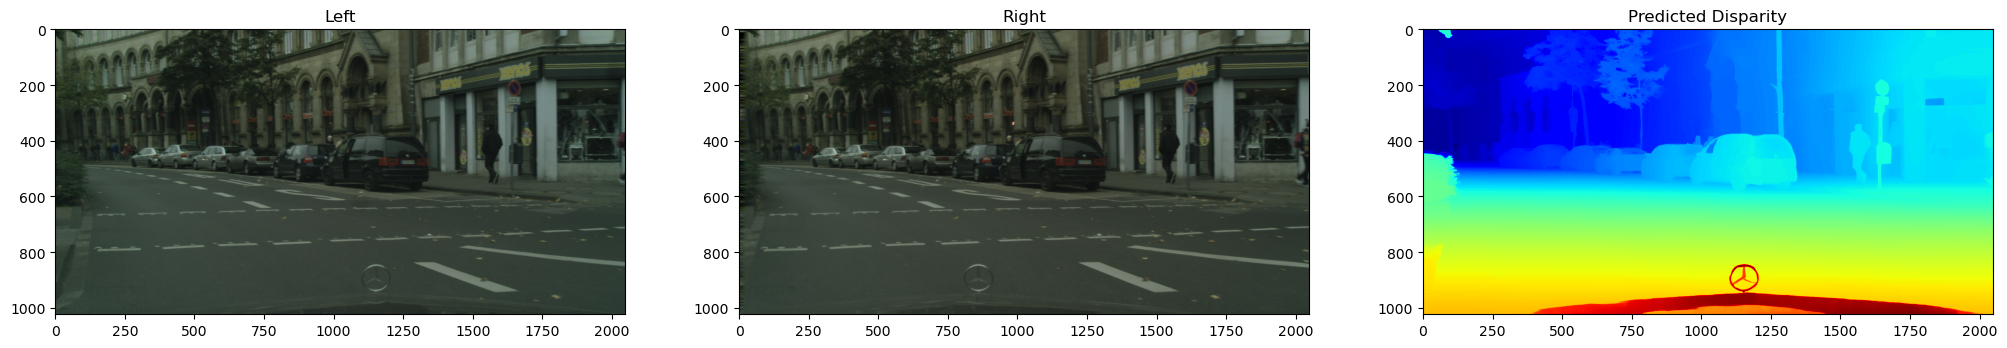

In [ ]:
_, ax = plt.subplots(1, 3, figsize=(25, 15))
ax[0].imshow(left)
ax[0].set_title("Left")
ax[1].imshow(right, cmap='jet')
ax[1].set_title("Right")
ax[2].imshow(np.log(pred_disp), cmap='jet')
ax[2].set_title("Predicted Disparity");

## Make a pipeline to predict displarity for all images

In [ ]:
def get_disparity(left, right):

	# place resize and place on device
	left_dw2 = F.interpolate(
		left,
		size=(H2, W2),
		mode="bilinear",
		align_corners=True,
	).to(device)

	right_dw2 = F.interpolate(
		right,
		size=(H2, W2),
		mode="bilinear",
		align_corners=True,
	).to(device)

	# perform inference
	with torch.inference_mode():
		pred_flow_dw2 = model(left_dw2, right_dw2, iters=n_iter, flow_init=None)
		del left_dw2, right_dw2
		pred_flow = model(left.to(device), right.to(device), iters=n_iter, flow_init=pred_flow_dw2)


	return torch.squeeze(pred_flow[:, 0, :, :]).cpu().detach().numpy()

In [ ]:
def make_dir(dirpath):
    try:
        os.mkdir(dirpath)
    except:
        try:
            os.mkdir(os.path.split(dirpath)[0])
        except:
            os.mkdir(os.path.split(os.path.split(dirpath)[0])[0])

Create new directories for dat

In [ ]:
disp_dir = os.path.join(root, 'crestereo_disparity')
depth_dir = os.path.join(root, 'crestereo_depth')

if not os.path.exists(disp_dir): os.mkdir(disp_dir)
if not os.path.exists(depth_dir): os.mkdir(depth_dir)

In [ ]:
for split in ['val']: # ['train', 'val']: # ('train', 'val', 'test'):
    # create split directories
    disp_split_dir = os.path.join(disp_dir, split)
    depth_split_dir = os.path.join(depth_dir, split)

    if not os.path.exists(disp_split_dir): os.mkdir(disp_split_dir)
    if not os.path.exists(depth_split_dir): os.mkdir(depth_split_dir)

    # get dataloader
    data_loader = DataLoader(CityScapesStereo(root, transform, split, True), batch_size, pin_memory=True)

    # get depth and disparity for all image pairs
    for i, (left, right, left_path, _) in enumerate(data_loader):

        disp_savepath = left_path[0].replace('leftImg8bit', 'crestereo_disparity')
        depth_savepath = left_path[0].replace('leftImg8bit', 'crestereo_depth')

        # special case for when the file already exist
        if os.path.exists(disp_savepath) and os.path.exists(depth_savepath):
            continue

        disp_dirname, _= os.path.split(disp_savepath)
        depth_dirname, _= os.path.split(depth_savepath)
        if not os.path.exists(disp_dirname): os.mkdir(disp_dirname)
        if not os.path.exists(depth_dirname): os.mkdir(depth_dirname)

        pred_disparity = get_disparity(left, right)
        pred_depth = baseline * f / (pred_disparity + 0.1)

        cv2.imwrite(disp_savepath, pred_disparity)
        cv2.imwrite(depth_savepath, pred_depth)

In [ ]:
disp_savepath

'C:/Users/itber/Documents/datasets/cityscapes\\crestereo_disparity\\train\\zurich\\zurich_000121_000019_crestereo_disparity.png'

In [ ]:
left_path

['C:/Users/itber/Documents/datasets/cityscapes\\leftImg8bit\\train\\zurich\\zurich_000121_000019_leftImg8bit.png']

In [ ]:
data_loader = DataLoader(CityScapesStereo(root, transform, split, True), batch_size, pin_memory=True)